In [14]:
import urllib.request
import zipfile
import os

In [16]:
# Source URL
url = "https://openzu.cuzk.cz/opendata/Data250/epsg-5514/data250.zip"

# Cíl, kam se ZIP soubor uloží
zip_filename = "data250.zip"

# Stáhni ZIP soubor
urllib.request.urlretrieve(url, zip_filename)
print(f"Soubor {zip_filename} byl úspěšně stažen.")

Soubor data250.zip byl úspěšně stažen.


In [17]:
# Cíl pro extrahování souborů
extract_folder = "extracted_files"
os.makedirs(extract_folder, exist_ok=True)

# Rozbalení ZIP souboru
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
    print(f"Soubor {zip_filename} byl úspěšně rozbalen do složky {extract_folder}.")

# Prohledání extrahované složky pro .shp soubor
shp_files = [f for f in os.listdir(extract_folder) if f.endswith('.shp')]

# Výpis nalezených .shp souborů
if shp_files:
    print(f"Nalezené .shp soubory: {shp_files}")
else:
    print("Nebyl nalezen žádný .shp soubor.")

Soubor data250.zip byl úspěšně rozbalen do složky extracted_files.
Nalezené .shp soubory: ['AirfldA.shp', 'AirfldC.shp', 'AirfldP.shp', 'BuildP.shp', 'BuiltupA.shp', 'BuiltupP.shp', 'CtowerP.shp', 'DamC.shp', 'DamL.shp', 'ElevL.shp', 'ElevP.shp', 'ExtractP.shp', 'FerryC.shp', 'FerryL.shp', 'GName5A.shp', 'GName5AT.shp', 'GName6A.shp', 'GName6AT.shp', 'GName7A.shp', 'GName7AT.shp', 'HarborP.shp', 'HeliP.shp', 'IndprodL.shp', 'IndprodP.shp', 'IntercC.shp', 'IslandA.shp', 'LakeresA.shp', 'LandmrkP.shp', 'LevelcC.shp', 'ParkA.shp', 'PhysL.shp', 'PhysP.shp', 'PolbndDA.shp', 'PolbndDistDA.shp', 'PolbndL.shp', 'PolbndMunDA.shp', 'PolbndP.shp', 'PolbndRegDA.shp', 'PowerL.shp', 'PowerP.shp', 'RailrdC.shp', 'RailrdL.shp', 'RapidsC.shp', 'RestC.shp', 'RoadL.shp', 'RunwayL.shp', 'SpringC.shp', 'SpringP.shp', 'SwampA.shp', 'TowerP.shp', 'VegA.shp', 'WatrcrsA.shp', 'WatrcrsL.shp']


In [73]:
import fiona

nuts_name = "Katovice"
with fiona.open('extracted_files/PolbndMunDA.shp') as nuts:  
    nuts_crs = nuts.crs
    for feature in nuts:
        if feature["properties"]["NAMN"] == nuts_name:
            aoi = feature["geometry"]
            break
            
nuts_crs, len(aoi.coordinates[0])


# import fiona
# aoi=fiona.open('extracted_files/PolbndDistDA.shp')["geometry"]

(CRS.from_epsg(5514), 76)

<Axes: >

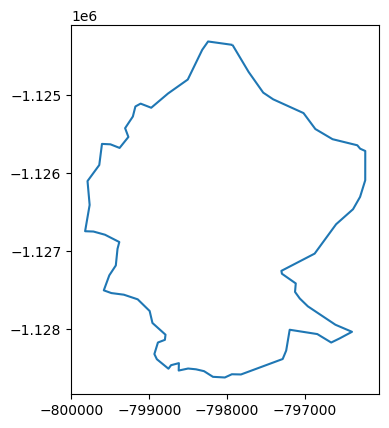

In [74]:
import geopandas as gpd
aoi_g = gpd.GeoSeries([aoi])
aoi_g.boundary.plot()

In [75]:
aoi_map = aoi_g.set_crs(epsg=5514)
aoi_map.explore()

In [76]:
from eodag import EODataAccessGateway
dag = EODataAccessGateway()
product = "S2_MSI_L2A"
dag.available_providers(product)

['astraea_eod',
 'cop_dataspace',
 'creodias',
 'onda',
 'planetary_computer',
 'sara']

In [77]:
extent = tuple(aoi_map.to_crs(4326).total_bounds)
extent
dag.set_preferred_provider("cop_dataspace")
results = dag.search(
    productType="S2_MSI_L2A",
    start="2024-10-01",
    end="2024-10-23",
    geom=tuple(extent),
    count=True
)
print(results.number_matched)

8


In [78]:
results_cc = results.filter_property(operator="le", cloudCover=5)
results_cc

SearchResult([EOProduct(id=S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806, provider=cop_dataspace)])

In [54]:
username = "cernote2@cvut.cz"
password = "Copernicus*2024UZPR"

dag.update_providers_config(f"""
cop_dataspace:
    download:
        extract: False
        outputs_prefix: /tmp/sentinel
        delete_archive: False
    auth:
        credentials:
            username: {username}
            password: {password}
""")

quicklooks/S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806: 0.00B [00:00, ?B/s]


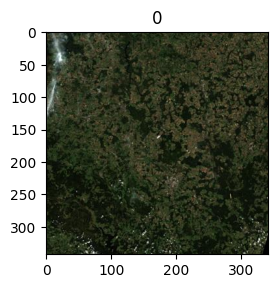

In [55]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 8))
for i, product in enumerate(results_cc, start=1):
    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook()

    # Plot the quicklook
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(3, 4, i)
    ax.set_title(i - 1)
    plt.imshow(img)
plt.tight_layout()

In [57]:
from pathlib import Path
data_path = dag.download(results_cc[0])



0.00B [00:00, ?B/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806: 0.00B [00:00, ?B/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|                        | 0.00/1.18G [00:00<?, ?B/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|              | 65.5k/1.18G [00:00<1:57:16, 168kB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|                | 590k/1.18G [00:00<13:37, 1.44MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|               | 1.44M/1.18G [00:00<05:57, 3.30MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|               | 2.23M/1.18G [00:00<04:44, 4.15MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|               | 3.01M/1.18G [00:00<03:51, 5.09MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|               | 4.00M/1.18G [00:00<03:07, 6.29MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132

C:\Users\terce\AppData\Local\Temp\S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806.SAFE.zip True


In [58]:
print(data_path, Path(data_path).exists())

C:\Users\terce\AppData\Local\Temp\S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806.SAFE.zip True
